<a href="https://colab.research.google.com/github/colaprograms/2019-hackathon-ocr-wymbah/blob/master/notebooks/ctc_test_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import os, torch, re, sys
import numpy as np
import matplotlib.pyplot as p
import random, PIL

In [10]:
PATH = "."
os.chdir(PATH)
if not os.path.exists(PATH + "/AI4Good---Meza-OCR-Challenge"):
  !git clone https://github.com/Charitable-Analytics-International/AI4Good---Meza-OCR-Challenge
if not os.path.exists(PATH + "/2019-hackathon-ocr-wymbah"):
  !git clone https://github.com/colaprograms/2019-hackathon-ocr-wymbah
os.chdir(PATH + "/2019-hackathon-ocr-wymbah")
!git pull

from importlib import reload
import util.file
reload(util.file)

"""
from google.colab import drive
drive.mount("/content/gdrive")
try:
  os.mkdir("/content/gdrive/My Drive/code")
except:
  pass
try:
  os.mkdir("/content/gdrive/My Drive/code/checkpoint")
except:
  pass"""

Cloning into 'AI4Good---Meza-OCR-Challenge'...
remote: Enumerating objects: 7262, done.
remote: Counting objects: 100% (7262/7262), done.
remote: Compressing objects: 100% (6869/6869), done.
remote: Total 7262 (delta 394), reused 7261 (delta 393), pack-reused 0
Receiving objects: 100% (7262/7262), 8.15 MiB | 9.84 MiB/s, done.
Resolving deltas: 100% (394/394), done.
Cloning into '2019-hackathon-ocr-wymbah'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 239 (delta 5), reused 0 (delta 0), pack-reused 223
Receiving objects: 100% (239/239), 367.03 KiB | 4.17 MiB/s, done.
Resolving deltas: 100% (109/109), done.
Already up to date.
Using path ../AI4Good---Meza-OCR-Challenge


'\nfrom google.colab import drive\ndrive.mount("/content/gdrive")\ntry:\n  os.mkdir("/content/gdrive/My Drive/code")\nexcept:\n  pass\ntry:\n  os.mkdir("/content/gdrive/My Drive/code/checkpoint")\nexcept:\n  pass'

144


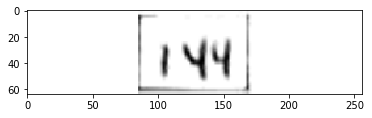

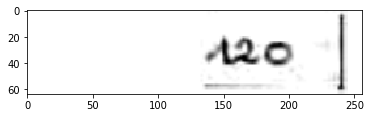

In [12]:
from util.file import FileHolder
fh = FileHolder()
inp, outp = fh.get_batch(1)

for file, val in zip(inp, outp):
  print(val)
  p.imshow(file)
  p.show()

def to_tensor(buf):
  buf -= 0.5
  buf *= 2
  #buf -= np.mean(buf, axis=(0, 1, 2))[None, None, None, :]
  #buf /= np.std(buf, axis=(0, 1, 2))[None, None, None, :]
  #buf -= np.array([0.485, 0.456, 0.406])[None, None, None, :]
  #buf /= np.array([0.229, 0.224, 0.225])[None, None, None, :]
  return torch.tensor(buf, dtype=torch.float32).permute(0, 3, 1, 2)

def get_batch(batchsize, validation=False):
  inp, outp = fh.get_batch(batchsize, validation)
  inp = np.stack(inp)
  inp = to_tensor(inp)
  return inp, outp

b = get_batch(1)[0].numpy().squeeze().transpose(1, 2, 0)
#print(np.min(b), np.max(b), np.mean(b), np.std(b))
p.imshow(get_batch(1)[0].numpy().squeeze().transpose(1, 2, 0) * 0.5 + 0.5)
p.show()

In [13]:
import torch.nn as nn
import torch.optim as optim
import torchvision



In [14]:
chars = " 0123456789-,."
nchars = len(chars)
idx = {}
for i, c in enumerate(chars): idx[c] = i

ntraining = len(fh.info['training'])

BATCH_SIZE = 64

def maketarget(outputs):
  classes = []
  for string in outputs:
    classes.extend([idx[c] for c in string])
    lengths = [len(string) for string in outputs]
  return torch.tensor(classes, dtype=torch.long), lengths

trainloss = []
validloss = []
def run():
  """resnet = torchvision.models.resnet.resnet34(True)

  "Cut off the last two layers"
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    #x = self.layer4(x)

    return x

  import types
  resnet.forward = types.MethodType(forward, resnet)
  resnet = resnet.cuda()
  for param in resnet.parameters():
    param.requires_grad = False
  """
  conv = nn.Sequential(
      nn.Conv2d(3, 64, (3, 3), padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, (3, 3), stride=2, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, (3, 3), padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 128, (3, 3), stride=2, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Conv2d(128, 128, (3, 1), padding=(1, 0)),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Conv2d(128, 128, (3, 1), stride=2, padding=(1, 0)),
      nn.BatchNorm2d(128),
      nn.ReLU(),
  ).cuda()
  lstm1 = nn.LSTM(128, 256, batch_first=True, bidirectional=True).cuda()
  layernorm1 = nn.LayerNorm((512,)).cuda()
  dense1 = nn.Sequential(
      nn.Linear(512, 256),
      nn.LayerNorm(256),
      nn.ReLU()
  ).cuda()
  dense2 = nn.Sequential(
      nn.Linear(256, nchars)
  ).cuda()
  def params():
    yield from lstm1.parameters()
    yield from dense1.parameters()
    yield from dense2.parameters()
    yield from conv.parameters()
  avgpool = nn.AdaptiveAvgPool2d((1, 32)).cuda()
  ctc = nn.CTCLoss(reduction='sum').cuda()
  
  optimizer = optim.SGD(params(), lr=0.001, momentum=0.9, nesterov=True)

  def input_to_string(inp):
    assert inp.shape[0] == 1
    inp = inp.detach().cpu().numpy()
    def randchoice(p):
      p = np.exp(p)
      u = random.random()
      for i in range(p.shape[0]):
        u -= p[i]
        if u < 0:
          return i
      raise Exception("not a probability distribution")
    return "".join(chars[randchoice(inp[0, j, :])] for j in range(inp.shape[1]))
  def crunch_input(inp):
    inp = conv(inp.cuda())
    inp = avgpool(inp)
    inp = inp.reshape([-1, 128, 32]).permute(0, 2, 1)
    # batch, seq, channels
    inp, _ = lstm1(inp)
    inp = layernorm1(inp)
    inp = dense1(inp)
    inp = dense2(inp)
    inp = nn.functional.log_softmax(inp, dim=2)
    return inp
  def crunch(inp, outp):
    inp = crunch_input(inp)
    inp = inp.permute(1, 0, 2)
    assert inp.shape[0] == 32
    input_lengths = [32 for i in range(inp.shape[1])]
    target, target_lengths = maketarget(outp)
    input_lengths, target_lengths = map(tuple, [input_lengths, target_lengths])
    loss = ctc(inp, target.data.cuda(), input_lengths, target_lengths)
    return loss
  for epoch in range(999999):
    running_loss = 0.0
    length = 0
    print("Example output:")
    inp, outp = get_batch(1)
    with torch.no_grad():
      string = input_to_string(crunch_input(inp))
    print(string, outp)
    for i in range(160):
      inp, outp = get_batch(BATCH_SIZE)
      optimizer.zero_grad()
      loss = crunch(inp, outp)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      length += BATCH_SIZE
    loss = None
    trainingloss = running_loss / length
    print("Epoch %d. Loss: %f" % (epoch, trainingloss))
    trainloss.append(trainingloss)
    running_loss = 0.0
    length = 0
    with torch.no_grad():
      for i in range(20):
        inp, outp = get_batch(BATCH_SIZE, validation=True)
        loss = crunch(inp, outp)
        running_loss += loss.item()
        length += BATCH_SIZE
    validationloss = running_loss / length
    print("Validation loss: %f" % validationloss)
    validloss.append(validationloss)
    file = "/content/gdrive/My Drive/code/checkpoint/checkpoint-%04d-%.2f" % (epoch, validationloss)
    torch.save({
        'lstm1': lstm1.state_dict(),
        'dense1': dense1.state_dict(),
        'dense2': dense2.state_dict(),
        'conv': conv.state_dict(),
        'trainloss': trainloss,
        'validloss': validloss
    }, file)
    print("Saved", file)

run()

RuntimeError: CuDNN error: CUDNN_STATUS_SUCCESS

In [0]:
image_tensor = torch.Tensor(image)
image_tensor = torch.unsqueeze(image_tensor, 0)
image_tensor = image_tensor.permute(0, 3, 1, 2)
out = resnet(image_tensor)
print(out)
print(out.shape)

In [0]:
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
7878787878787878787878787878787878787878787878787878787878787878787878787878787878787878787878787878787878787878787878787878787878787878787878787878787878787878[pppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppmjnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx]'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''